# Optimization in Data Science Part 3

Referenced Textbook: https://cobweb.cs.uga.edu/~jam/scalation_guide/comp_data_science.pdf

Specifically Appendix A (Starting Page 619)

## Stochastic Gradient Descent with Momentum (SGDM)

So, now that been over SGD and its benefits how can we improve it further?

Well, SGD has a known problem. SGD has trouble navigating ravines, i.e. areas where the surface curves much more steeply in one dimension than in another, which are common around local optima. In these scenarios, SGD oscillates across the slopes of the ravine while only making hesitant progress along the bottom towards the local optimum as in Image 2. This hesistation may even results in scenarios where the global optimum solution is never found!

![](./pics/sgdm/sgd_prob.jpg)

Source: https://ruder.io/optimizing-gradient-descent/index.html#momentum

How can we fix this problem?

We can implement a strategy known as momentum. In this strategy, we will take a weighted average of the current gradient and the previous gradients. We will give preference to the more recent gradients by allowing previous gradients contributions to be exponentially decayed. This makes sense because in theory the previous gradients closest to the current gradient should give us a better idea of the direction we need to continue in that the previous gradients farther away. 

To do this, we need some way to weight the gradients:

![](./pics/sgdm/sgdm_eqn.jpg)

p is this case will replace the gradient (g) we were using perviously in SGD. We will also introduced a new hyperparameter here called the decay rate, β. This parameter controls how fast prior gradients are discounted. β is commonly set at 0.9

If β is zero, that algorithm behaves the same as Stochastic Gradient Descent. At the other extreme, if β is 1, there is no decay and all previous gradients will weigh in, so eventually the new gradient value will have little impact and the algorithm will become oblivious to its local environment.

Finally, when updating the parameter (weights) vector x, the hyperparameter ν determines how much weight to place on the current gradient versus the
momentum when updating the parameter vector x. There are two special cases to consider.

When v is 0, the algorithm becomes the originally SGD, and when x is 1, the algorithm becomes SGD with only momentum

## Perceptron Code with SGD with Momentum

In [82]:
import numpy as np
from tensorflow.keras import activations
import matplotlib.pyplot as plt
import numpy as np

### Initializing Data

In [83]:

# 10 data points: one x1 x2 y
xy = np.matrix (
[[1.0, 0.0, 0.0, 0.5],
[1.0, 0.0, 0.5, 0.3],
[1.0, 0.0, 1.0, 0.2],
[1.0, 0.5, 0.0, 0.8],
[1.0, 0.5, 0.5, 0.5],
[1.0, 0.5, 1.0, 0.3],
[1.0, 1.0, 0.0, 1.0],
[1.0, 1.0, 0.5, 0.8],
[1.0, 1.0, 1.0, 0.5],
[1.0, 1.0, 1.0, 0.6]]
)

# Taking first 3 columns of xy as matrix
x = xy[:,0:3]

# Taking last column of xy as array
y = xy[:, 3]

# Initializing B matrix
b = np.matrix (
[[0.1],
[0.2],
[0.1]]
)

### Finding SST

In [84]:
# Create a function to find SST 

def getSST (target):
    
    # Finding the sum of squares total
    y_mean = np.mean (target)
    sst = 0

    for each in target:
        sst = sst + (each - y_mean) ** 2

    # This just pulls the sst value out of the matrix to make it easier to work with
    sst = np.ndarray.item(sst)
    
    return sst

### Assigning Batches

In [85]:
# Create a function to randomly break data in batches based on batch size
# This function ensures that all data will be represented in a batch and that each batch is randomly selected

import math

def makeBatches(data, bs):
    
   num_batch = math.ceil(data.shape[0] / bs)
    
   pos_choices = range(0, data.shape[0])
   
   rand_list = np.random.choice(pos_choices, data.shape[0], False)
   
   batch_list = np.split(rand_list, num_batch)
      
   return batch_list

### Getting Values for Batches

In [86]:
# Create a function to actually get value from original training set based on batch_list

def getBatchVals(batch):
    
    batch_vals_x = []
    batch_vals_y = []
    
    for each in batch:
        batch_vals_x.append((x[each][:]).tolist()[0])
        batch_vals_y.append((y[each][:]).tolist()[0])

    batch_vals_x = np.matrix(batch_vals_x)
        
    return batch_vals_x, batch_vals_y

### Calculating Gradient

In [87]:
# Create a function to calcuate gradients

def calcGrad (x, y, b):
    
    # Pre-activation vector
    u = np.dot(x, b)
    
    # Predicted value vector
    y_hat = activations.sigmoid(u)
    
    # Negative error vector
    e = y - y_hat
    
    # Correction vector (delta or d)
    d = - e * (y_hat * (1 - y_hat))
    
    # Gradients vector
    grad = np.transpose(x).dot(d)
    
    # Sum of squared errors
    sse = np.sum(e * e)
    
    return grad, sse

### Setting Hyperparameters

In [88]:
# Setting new_parms = b so original value will not get over written
new_parms = b

# Lists to hold values for plotting
sse_list = []
rsq_list = []
x_list = []

# Find SST
sst = getSST(y)

# Set max epochs
max_iters = 100

# Set bath size
batch_size = 5

# Set learning rate
eta = 1

# Set decay rate
# Standard value is 0.9
beta = .9

# Set v 
nu = .5

### Performing SGD with Momentum

In [89]:
# Outer loop handles interations for epochs
for i in range(0, max_iters):
    
    # Randomly getting list of index positions of origional data for batches
    batch_list = makeBatches(x, batch_size)

    # Resetting momentum for each iteration
    momentum_list = []
    inc = 0
    
    # Inner loop iterated through all batches of data in each epoch
    for batch in batch_list:
        
        # Getting data associated with each batch
        batch_vals_x, batch_vals_y = getBatchVals(batch)
        
        # Calculating gradients
        grad, sse = calcGrad(batch_vals_x, batch_vals_y, new_parms)
        
        # Getting first momentum value
        if (inc == 0):
            momentum_list.append((1 - beta) * grad)
        # Getting all other momentum values from previous momentum value
        else:
            momentum_list.append((1 - beta) * grad + beta * momentum_list[inc - 1])
            
            
        # Updated weights vector
        new_parms = new_parms - eta * ( (1 - nu) * grad + nu * momentum_list[inc] )
        # print (momentum_list)

    # Appending all to lists so we can plot later
    x_list.append(i)
    sse_list.append(sse)
    rsq_list.append(1-sse/sst)

### Plots

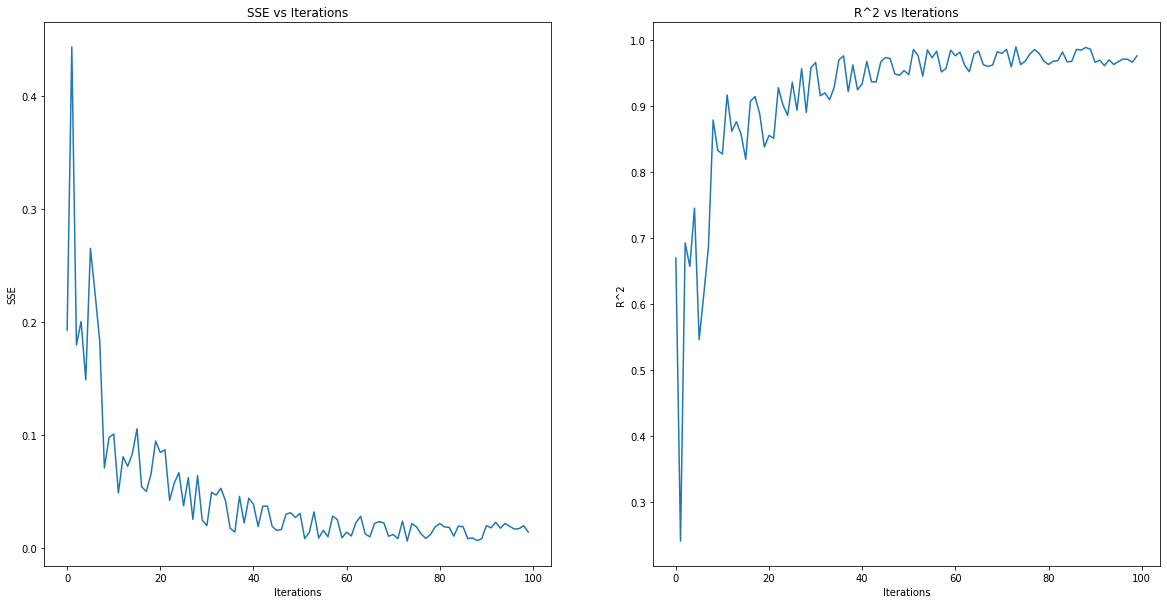

In [90]:
# To plot our findings

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(x_list, sse_list)
plt.title('SSE vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('SSE')

plt.subplot(1, 2, 2)
plt.plot(x_list, rsq_list)
plt.title("R^2 vs Iterations")
plt.xlabel('Iterations')
plt.ylabel('R^2')


plt.show()